In [1]:

import geopandas as gpd
import atlite
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import functools

In [2]:
xr.open_dataset("../build/cutouts/cutout-era5-model-level.nc")

<xarray.Dataset>
Dimensions:    (longitude: 217, latitude: 161, time: 52584)
Coordinates:
  * longitude  (longitude) float32 -17.0 -16.75 -16.5 -16.25 ... 36.5 36.75 37.0
  * latitude   (latitude) float32 72.0 71.75 71.5 71.25 ... 32.5 32.25 32.0
  * time       (time) datetime64[ns] 2013-01-01 ... 2018-12-31T23:00:00
Data variables:
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-21 18:47:12 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [2]:
# boundaries = open("../data/europe-98-zones.geojson/europe-98-zones.geojson")
boundaries = "../build/shapes/eez.geojson"
natura2000 = "../data/potentials_offshore/natura2000_areas/eea_v_3035_100_k_natura2000_p_2021_v12_r01/SHP/Natura2000_end2021_rev1_epsg3035.shp"
shipdensity = "../data/potentials_offshore/shipping_density_global/shipdensity_global.tif"
gebco = "../data/potentials_offshore/gebco_2023_sub_ice_topo/GEBCO_2023_sub_ice_topo.nc"


In [3]:
df_boundaries = gpd.read_file(boundaries)

In [4]:

df_natura2000 = gpd.read_file(natura2000)
df_shipdensity = None


<Axes: >

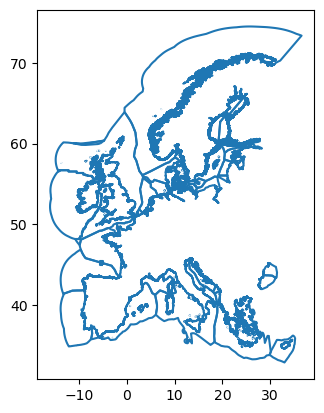

In [5]:
df_boundaries.boundary.plot()

In [6]:
deu = df_boundaries.loc[df_boundaries["iso_ter1"] == "DEU"]

In [7]:
# Load all exclusion shapes to generate potentials
# TODO: which crs?
# TODO: res determined by coarsest dataset?
excluder = atlite.ExclusionContainer()

excluder.add_geometry(natura2000)  # which crs?

max_depth = 60
func = functools.partial(np.greater, -max_depth)
excluder.add_raster(gebco, crs=4326, codes=func)  # which crs?

# TODO: Can I save data to plot potentials as shapefile? Or is it only available as raster data?
masked, transform = excluder.compute_shape_availability(df_boundaries)

In [44]:
excluder.rasters[0]["invert"] = False

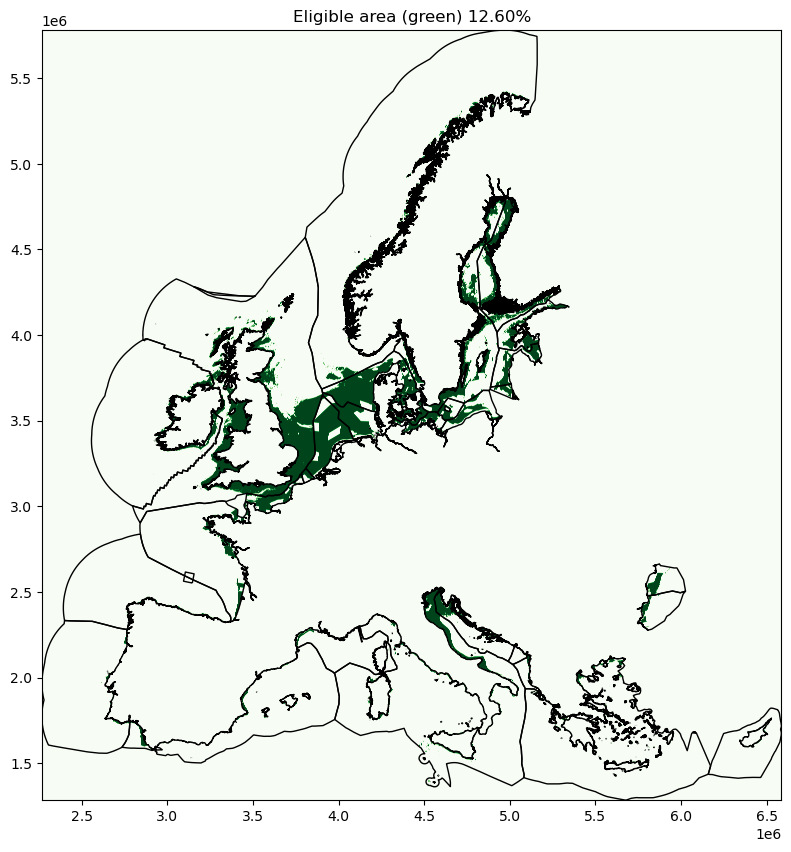

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
excluder.plot_shape_availability(df_boundaries, ax=ax)
plt.show()

In [50]:
cutout = atlite.Cutout(boundaries)
availability = cutout.availabilitymatrix(regions, excluder, **kwargs)

TypeError: Arguments 'time' and 'module' must be specified. Spatial bounds must either be passed via argument 'bounds' or 'x' and 'y'.

In [9]:
atlite.data.available_features()

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
sarah   influx            influx_direct
        influx           influx_diffuse
        influx           solar_altitude
        influx            solar_azimuth
gebco   height                   height
Name: variables, dtype: object

In [15]:
cutout = atlite.Cutout(path="../build/cutouts/cutout-era5-model-level_adapted.nc")
for v in cutout.data:
    cutout.data[v].attrs["feature"] = v
    cutout.data[v].attrs["module"] = "era5-ml"
cutout

<Cutout "cutout-era5-model-level_adapted">
 x = -17.00 ⟷ 37.00, dx = 0.25
 y = 72.00 ⟷ 32.00, dy = -0.25
 time = 2013-01-01 ⟷ 2018-12-31, dt = H
 module = era5
 prepared_features = ['u', 'v']

In [2]:
def _rename_and_clean_coords(ds, add_lon_lat=True):
    """
    Rename 'longitude' and 'latitude' columns to 'x' and 'y' and fix roundings.

    Optionally (add_lon_lat, default:True) preserves latitude and
    longitude columns as 'lat' and 'lon'.
    """
    ds = ds.rename({"longitude": "x", "latitude": "y"})
    # round coords since cds coords are float32 which would lead to mismatches
    ds = ds.assign_coords(
        x=np.round(ds.x.astype(float), 5), y=np.round(ds.y.astype(float), 5)
    )

    if add_lon_lat:
        ds = ds.assign_coords(lon=ds.coords["x"], lat=ds.coords["y"])

    return ds


modellevel = xr.open_dataset("../build/cutouts/cutout-era5-model-level.nc")

modellevel.attrs["module"] = "era5"
modellevel.attrs["dx"] = 0.25
modellevel.attrs["dy"] = 0.25
modellevel.attrs["prepared_features"] = ["u", "v"]
modellevel = _rename_and_clean_coords(modellevel)
modellevel
modellevel.to_netcdf("../build/cutouts/cutout-era5-model-level_adapted.nc")

In [6]:
for v in modellevel:
    modellevel[v].attrs["feature"] = v
    modellevel[v].attrs["module"] = "era5-ml"

In [3]:
ml = xr.open_dataset("../build/cutouts/cutout-era5-model-level_adapted.nc")

In [4]:
ml

<xarray.Dataset>
Dimensions:  (x: 217, y: 161, time: 52584)
Coordinates:
  * x        (x) float64 -17.0 -16.75 -16.5 -16.25 ... 36.25 36.5 36.75 37.0
  * y        (y) float64 72.0 71.75 71.5 71.25 71.0 ... 32.75 32.5 32.25 32.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2018-12-31T23:00:00
    lon      (x) float64 ...
    lat      (y) float64 ...
Data variables:
    u        (time, y, x) float32 ...
    v        (time, y, x) float32 ...
Attributes:
    Conventions:        CF-1.6
    history:            2023-08-31 22:03:29 GMT by grib_to_netcdf-2.25.1: /op...
    module:             era5
    dx:                 0.25
    dy:                 0.25
    prepared_features:  ['u', 'v']

In [6]:
xr.open_dataset("../build/cutouts/cutout-era5.nc")

<xarray.Dataset>
Dimensions:           (x: 180, y: 134, time: 8760)
Coordinates:
  * x                 (x) float64 -16.8 -16.5 -16.2 -15.9 ... 36.3 36.6 36.9
  * y                 (y) float64 32.1 32.4 32.7 33.0 ... 71.1 71.4 71.7 72.0
  * time              (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
    lon               (x) float64 ...
    lat               (y) float64 ...
Data variables: (12/13)
    height            (y, x) float32 ...
    wnd100m           (time, y, x) float32 ...
    wnd_azimuth       (time, y, x) float32 ...
    roughness         (time, y, x) float32 ...
    influx_toa        (time, y, x) float32 ...
    influx_direct     (time, y, x) float32 ...
    ...                ...
    albedo            (time, y, x) float32 ...
    solar_altitude    (time, y, x) float64 ...
    solar_azimuth     (time, y, x) float64 ...
    temperature       (time, y, x) float32 ...
    soil temperature  (time, y, x) float32 ...
    runoff            (time, y, x) float32 ...
Attributes:
    module:             era5
    prepared_features:  ['temperature', 'height', 'runoff', 'influx', 'wind']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2023-08-30 15:30:29 GMT by grib_to_netcdf-2.25.1: /op...

In [17]:
import atlite
import pandas as pd


snapshots = pd.date_range(freq="h", start="2014-01-01", end="2015-01-01", inclusive="left")
time = [snapshots[0], snapshots[-1]]

cutout = atlite.Cutout(time=time, x=slice(*[-17., 37.]), y=slice(*[32., 72.]), module="era5-ml", path="../build/cutouts/cutout-era5-ml-test.nc")
cutout.prepare(features="wind")


TypeError: unsupported operand type(s) for ** or pow(): 'dict' and 'dict'